# Extension: Example Usage for the _AsyncExplanationWrapper_

In order to fully leverage a machine's computing power, one needs to consider parallelizing a program. For that purpose, we have implemented the _Asynchronous Explanation Wrapper_. So given a series of images to be explained and a suitable inference model, this wrapper will generate explanations for respective image simultaneously and return a list of tuples containing the savepoints and corresponding meta data of that image. Under the hood, multithreading is applied to enable parallelization.

For this example, we will utilize the same MNIST data set and inference model as above. Most of the steps will be similar.

1. **Import the required libraries**:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import maxi

from official_mnist_tf.train_mnist_model import load_mnist, init_model

2022-06-02 13:11:34.401941: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


2. **Load the mnist data, model and autoencoder**:

In [ ]:
x_train, y_train, x_test, y_test = load_mnist()
model = init_model()
model.load_weights("../mnist/models/tf/tf")

3. **Chose images to be explained**:

In [3]:
idx = [2, 12, 46, 73]

inputs = [
    np.array([x_train[id]]) for id in idx
]


Note: The images have to be stored in a **list**.

This is how the images look like:

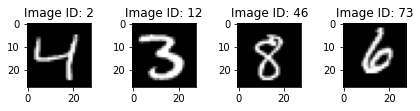

In [4]:
f, axarr = plt.subplots(1, len(inputs))
f.tight_layout()
for i, (id, input) in enumerate(zip(idx, inputs)):
    axarr[i].title.set_text(f"Image ID: {id}")
    axarr[i].imshow(
        input.squeeze(axis=0),
        cmap="gray",
        vmin=0.0,
        vmax=1.0,
    )

4. **Chose your desired component classes for the optimization (loss, optimizer and gradient). Then, specify the configuration of the components**:

In [5]:
loss_class = maxi.loss.TF_CEMLoss
optimizer_class = maxi.optimizer.AdaExpGradOptimizer
gradient_class = maxi.gradient.TF_Gradient

loss_kwargs = {"mode": "PP", "gamma": 0.0, "K": 2}
optimizer_kwargs = {"l1": 0.05, "l2": 0.005, "channels_first": False}
gradient_kwargs = {}

5. **Instantiate the ```ExplanationGenerator``` with our custom configuration**:

In [6]:
cem = maxi.ExplanationGenerator(
    loss=loss_class,
    optimizer=optimizer_class,
    gradient=gradient_class,
    loss_kwargs=loss_kwargs,
    optimizer_kwargs=optimizer_kwargs,
    gradient_kwargs=gradient_kwargs,
    num_iter=1000,
    save_freq=250,
)

6. **Wrap the ```ExplanationGenerator``` instance with the ```AsyncExplanationWrapper```**:

In [7]:
async_cem = maxi.AsyncExplanationWrapper(cem, n_workers=4)

Note: The `n_workers` argument sets the maximum number of workers (threads) to generate explainations.


7. **Setup the dictionaries that allocate the input images to the inference method and meta data**:


In [8]:
inference_calls = {img.tobytes(): model for img in inputs}

meta_data = {
    inputs[i].tobytes(): {"data_index": id} 
    for i, (id, _) in enumerate(zip(idx, inputs))
}

Note: It is essential to set the image bytes as the key in the dictionaries in order for the wrapper to assign the inference method/ meta information to the right image. The meta data can be optionally parsed but it is recommended as it may pose as an identicator for the results.

8.  **Start the explanation procedure and retrieve the results**:


In [9]:
results = async_cem.run(inputs, inference_calls, meta_data)

/home/tuananhroman/dai/constrastive-explaination-prototype/src/maxi/lib/computation_components/optimizer/ada_exp_grad.py:64: ComplexWarning: Casting complex values to real discards the imaginary part
  self.y[:] = 1.0 / self.t * self.x + (1 - 1.0 / self.t) * self.y
/home/tuananhroman/.cache/pypoetry/virtualenvs/maxi-ZjBXp4XP-py3.8/lib/python3.8/site-packages/tensorflow/python/framework/constant_op.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return ops.EagerTensor(value, ctx.device_name, dtype)


9. **Display the results**:


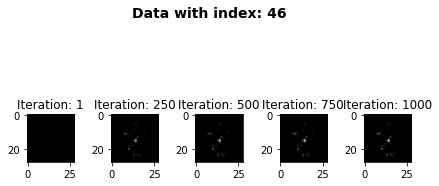

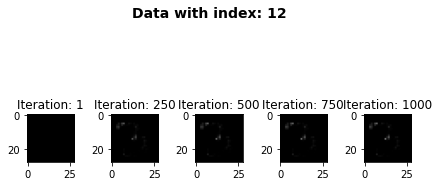

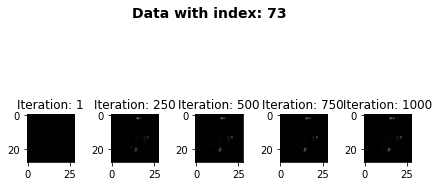

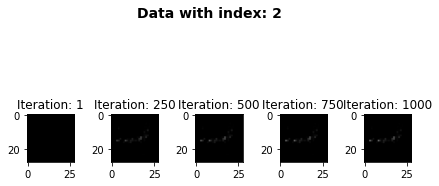

In [11]:
for savepoints, meta_data in results:
    data_idx = meta_data["data_index"]
    f, axarr = plt.subplots(1, len(savepoints))

    f.tight_layout()
    f.suptitle(f"Data with index: {data_idx}", fontsize=14, fontweight="bold")
    for i, (iter, result) in enumerate(savepoints.items()):
        axarr[i].title.set_text("Iteration: " + iter)
        axarr[i].imshow(result.squeeze(axis=0), cmap="gray", vmin=0.0, vmax=1.0)